# L1 spectrum masked value check

> Check that L1 pixels are masked where original counts are invalid.

In [ ]:
# |default_exp diagnostics.l1_spectrum_masked_value_check

In [ ]:
# |export

import matplotlib.pyplot as plt

from qagmire.data import (
    get_lr_l1_single_files,
    read_l1_data,
)
from qagmire.quality_assurance import Diagnostics

To write checks of the data, we create a subclass of `Diagnostics` and implement the `tests` method.

In [ ]:
# |export


class L1SpectrumMaskedValueCheck(Diagnostics):
    """L1 spectrum masked value check.

    A reproduction of the class with the same name in the weaveio
    [value_checks](https://github.com/bamford/QAG/blob/master/diagnostics/value_checks.py).

    This tests for the following cases:

    * Are there unmasked pixels (with ivar_noss > 0) where flux_noss < 0?
    * Are there unmasked pixels (with ivar_noss > 0) where flux_noss > linearity_threshold_adu?
    * Are there unmasked pixels (with ivar > 0) where flux_noss < 0?
    * Are there unmasked pixels (with ivar > 0) where flux_noss > linearity_threshold_adu?

    for the red and blue arrays.
    """

    def __init__(
        self,
        linearity_threshold_adu: float = 60000,  # the maximum original ADU to consider valid
        camera=None,  # limit to a specific camera: RED or BLUE
        **kwargs,  # additional keyword arguments are passed to the `Diagnostics` constructor
    ):
        self.linearity_threshold_adu = linearity_threshold_adu
        self.camera = camera.upper() if camera is not None else None
        super().__init__(**kwargs)

    def tests(self, **kwargs):
        files = get_lr_l1_single_files(**kwargs)
        data = read_l1_data(files)

        if self.camera is not None:
            camera_match = data["CAMERA"] == self.camera
            data = data.sel(filename=camera_match)
            cameras = [self.camera]
        else:
            cameras = ["RED", "BLUE"]

        # perform the tests by RUN, rather than filename
        data = data.swap_dims(filename="RUN")
        self.data = data

        tests = []
        for camera in cameras:
            flux_name = f"{camera}_FLUX_NOSS"
            negative_flux = data[flux_name] < 0
            nonlinear_flux = data[flux_name] > self.linearity_threshold_adu

            for ext in ["IVAR", "IVAR_NOSS"]:
                name = f"{camera}_{ext}"
                band = camera[0]
                unmasked = data[name] > 0
                unmasked_negative = unmasked & negative_flux
                unmasked_nonlinear = unmasked & nonlinear_flux
                any_unmasked_negative = unmasked_negative.any(dim=f"LAMBDA_{band}")
                any_unmasked_nonlinear = unmasked_nonlinear.any(dim=f"LAMBDA_{band}")
                tests.extend(
                    [
                        {
                            "name": f"neg_flux_unmasked_in_{name}",
                            "description": f"Are there unmasked pixels in {ext} where FLUX_NOSS is negative?",
                            "test": any_unmasked_negative,
                        },
                        {
                            "name": f"nlr_flux_unmasked_in_{name}",
                            "description": f"Are there unmasked pixels in {ext} where FLUX_NOSS is non-linear?",
                            "test": any_unmasked_nonlinear,
                        },
                    ]
                )
        return tests

## Demonstration tests

We use multiple `dask` workers to speed up this test. Checking 15 billion pixels takes ~45 seconds with 8 workers.

### Red camera

In [ ]:
red_tests = L1SpectrumMaskedValueCheck(camera="RED", n_processes=8)
red_tests.run(date="201*")

Locating and converting where necessary:   0%|                                                                                     | 0/126 [00:00<?, ?it/s]

Locating and converting where necessary: 100%|█████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 5493.46it/s]


Reading netCDF files... 

took 6.63 s. Size is 57535.394 Mb
Tests took 8.89 s to prepare (including reading data).


Tests took 19.75 s to perform.
neg_flux_unmasked_in_RED_IVAR:
    Are there unmasked pixels in IVAR where FLUX_NOSS is negative?
nlr_flux_unmasked_in_RED_IVAR:
    Are there unmasked pixels in IVAR where FLUX_NOSS is non-linear?
neg_flux_unmasked_in_RED_IVAR_NOSS:
    Are there unmasked pixels in IVAR_NOSS where FLUX_NOSS is negative?
nlr_flux_unmasked_in_RED_IVAR_NOSS:
    Are there unmasked pixels in IVAR_NOSS where FLUX_NOSS is non-linear?


In [ ]:
red_tests.summary(by="RUN")

4 varieties of test and 60480 tested elements per variety, for total of 241920 tests.
78820 tests failed (32.58%) and 163100 tests passed (67.42%).


failed                                     \
test    neg_flux_unmasked_in_RED_IVAR neg_flux_unmasked_in_RED_IVAR_NOSS   
RUN                                                                        
1003331                           917                                917   
1003329                           912                                912   
1003357                           911                                911   
1003333                           909                                909   
1003437                           908                                908   
...                               ...                                ...   
1004147                           290                                290   
1004111                           255                                255   
1004109                           250                                250   
1004113                           245                                245   
1004149                           274                                274   

                                                                          \
test    nlr_flux_unmasked_in_RED_IVAR nlr_flux_unmasked_in_RED_IVAR_NOSS   
RUN                                                                        
1003331                             0                                  0   
1003329                             0                                  0   
1003357                             0                                  0   
1003333                             0                                  0   
1003437                             0                                  0   
...                               ...                                ...   
1004147                             0                                  0   
1004111                            33                                 33   
1004109                            33                                 33   
1004113                            33                                 33   
1004149                             0                                  0   

        total fails  
test                 
RUN                  
1003331        1834  
1003329        1824  
1003357        1822  
1003333        1818  
1003437        1816  
...             ...  
1004147         580  
1004111         576  
1004109         566  
1004113         556  
1004149         548  

[63 rows x 5 columns]

In [ ]:
red_tests.summary(by="NSPEC")

4 varieties of test and 60480 tested elements per variety, for total of 241920 tests.
78820 tests failed (32.58%) and 163100 tests passed (67.42%).


failed                                     \
test  neg_flux_unmasked_in_RED_IVAR neg_flux_unmasked_in_RED_IVAR_NOSS   
NSPEC                                                                    
325                              59                                 59   
375                              61                                 61   
382                              57                                 57   
385                              60                                 60   
283                              57                                 57   
...                             ...                                ...   
942                               8                                  8   
944                               7                                  7   
960                               7                                  7   
943                               4                                  4   
959                               1                                  1   

                                                                        \
test  nlr_flux_unmasked_in_RED_IVAR nlr_flux_unmasked_in_RED_IVAR_NOSS   
NSPEC                                                                    
325                               8                                  8   
375                               6                                  6   
382                               9                                  9   
385                               6                                  6   
283                               6                                  6   
...                             ...                                ...   
942                               0                                  0   
944                               0                                  0   
960                               0                                  0   
943                               0                                  0   
959                               0                                  0   

      total fails  
test               
NSPEC              
325           134  
375           134  
382           132  
385           132  
283           126  
...           ...  
942            16  
944            14  
960            14  
943             8  
959             2  

[959 rows x 5 columns]

### Blue camera

In [ ]:
blue_tests = L1SpectrumMaskedValueCheck(camera="BLUE", n_processes=8)
blue_tests.run(date="201*")

Locating and converting where necessary:   0%|                                                                                     | 0/126 [00:00<?, ?it/s]

Locating and converting where necessary: 100%|█████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 5192.65it/s]


Reading netCDF files... 

took 5.71 s. Size is 57535.394 Mb
Tests took 7.96 s to prepare (including reading data).


Tests took 14.43 s to perform.
neg_flux_unmasked_in_BLUE_IVAR:
    Are there unmasked pixels in IVAR where FLUX_NOSS is negative?
nlr_flux_unmasked_in_BLUE_IVAR:
    Are there unmasked pixels in IVAR where FLUX_NOSS is non-linear?
neg_flux_unmasked_in_BLUE_IVAR_NOSS:
    Are there unmasked pixels in IVAR_NOSS where FLUX_NOSS is negative?
nlr_flux_unmasked_in_BLUE_IVAR_NOSS:
    Are there unmasked pixels in IVAR_NOSS where FLUX_NOSS is non-linear?


In [ ]:
blue_tests.summary(by="RUN")

4 varieties of test and 60480 tested elements per variety, for total of 241920 tests.
91920 tests failed (38.00%) and 150000 tests passed (62.00%).


failed                                      \
test    neg_flux_unmasked_in_BLUE_IVAR neg_flux_unmasked_in_BLUE_IVAR_NOSS   
RUN                                                                          
1003330                            937                                 937   
1003332                            937                                 937   
1003438                            937                                 937   
1003442                            937                                 937   
1002348                            936                                 936   
...                                ...                                 ...   
1004100                             96                                  96   
1004102                             91                                  91   
1004112                             87                                  87   
1004110                             82                                  82   
1004114                             67                                  67   

                                                                            \
test    nlr_flux_unmasked_in_BLUE_IVAR nlr_flux_unmasked_in_BLUE_IVAR_NOSS   
RUN                                                                          
1003330                              0                                   0   
1003332                              0                                   0   
1003438                              0                                   0   
1003442                              0                                   0   
1002348                              0                                   0   
...                                ...                                 ...   
1004100                             34                                  34   
1004102                             34                                  34   
1004112                              5                                   5   
1004110                              5                                   5   
1004114                              5                                   5   

        total fails  
test                 
RUN                  
1003330        1874  
1003332        1874  
1003438        1874  
1003442        1874  
1002348        1872  
...             ...  
1004100         260  
1004102         250  
1004112         184  
1004110         174  
1004114         144  

[63 rows x 5 columns]

In [ ]:
blue_tests.summary(by="NSPEC")

4 varieties of test and 60480 tested elements per variety, for total of 241920 tests.
91920 tests failed (38.00%) and 150000 tests passed (62.00%).


failed                                      \
test  neg_flux_unmasked_in_BLUE_IVAR neg_flux_unmasked_in_BLUE_IVAR_NOSS   
NSPEC                                                                      
261                               56                                  56   
273                               56                                  56   
280                               56                                  56   
298                               62                                  62   
343                               57                                  57   
...                              ...                                 ...   
943                               18                                  18   
945                               18                                  18   
958                               18                                  18   
956                               12                                  12   
950                                2                                   2   

                                                                          \
test  nlr_flux_unmasked_in_BLUE_IVAR nlr_flux_unmasked_in_BLUE_IVAR_NOSS   
NSPEC                                                                      
261                                6                                   6   
273                                6                                   6   
280                                6                                   6   
298                                0                                   0   
343                                3                                   3   
...                              ...                                 ...   
943                                0                                   0   
945                                0                                   0   
958                                0                                   0   
956                                0                                   0   
950                                0                                   0   

      total fails  
test               
NSPEC              
261           124  
273           124  
280           124  
298           124  
343           120  
...           ...  
943            36  
945            36  
958            36  
956            24  
950             4  

[960 rows x 5 columns]

## Verification

We now do some spot checks to verify and expand upon the above test results. Note that we assigned `self.data` inside `tests`. This provides a way of accessing the source data, without having to construct it again.

In [ ]:
# |export


def plot_unmasked_and_invalid(tests, run):
    data = tests.data.sel(RUN=run)
    flux = data[f"{tests.camera}_FLUX_NOSS"]
    neg = flux < 0
    nlr = flux > tests.linearity_threshold_adu
    ivar = data[f"{tests.camera}_IVAR_NOSS"]
    unmasked = ivar > 0
    fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True, sharey=True)
    ax[0].imshow(unmasked, interpolation="none", aspect="auto")
    ax[0].set_title("unmasked")
    ax[1].imshow(-1 * neg + nlr, vmin=-1, vmax=1, interpolation="none", aspect="auto")
    ax[1].set_title("invalid")
    fig.suptitle(f"RUN {run}")
    plt.tight_layout()

There is some odd striping of masked values in some spectra (@fig-bad), but those that look more sensible (@fig-good) contain a significant number of unmasked pixels (yellow in top panel) that have negative fluxes (blue in bottom panel) or are above the non-linear threshold (yellow in bottom panel).

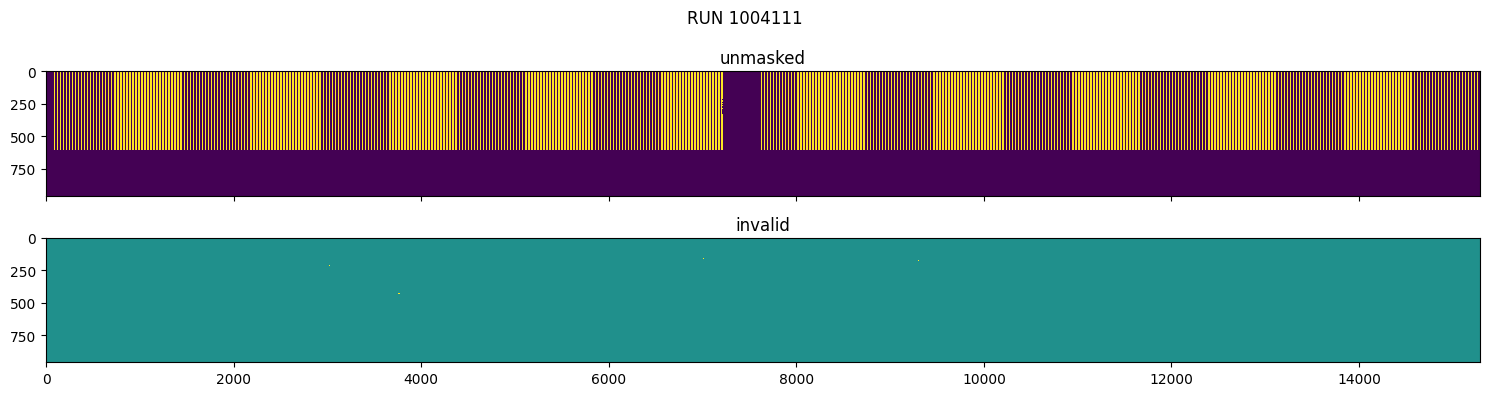

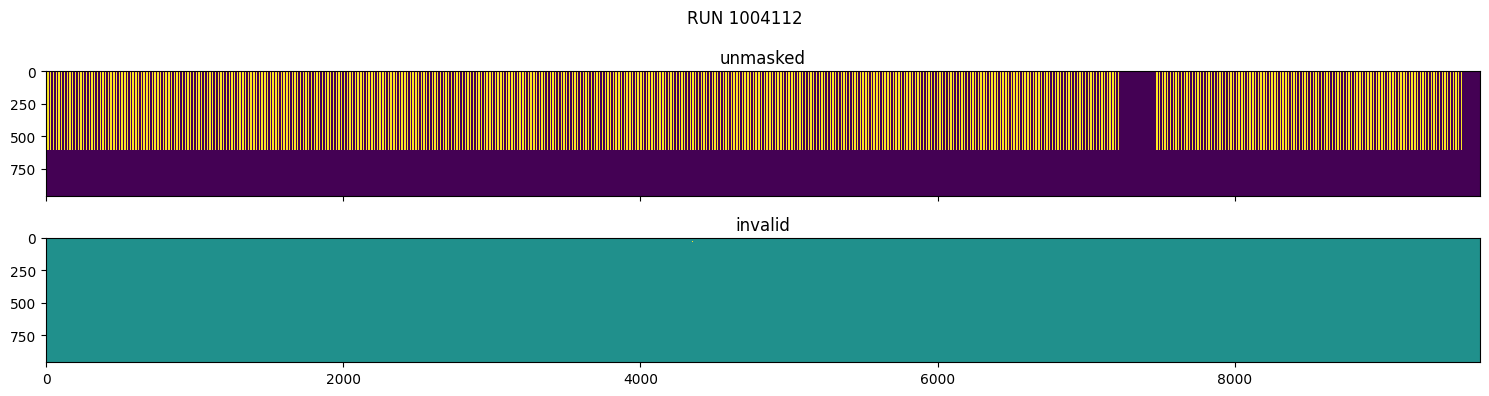

In [ ]:
# |label: fig-bad
plot_unmasked_and_invalid(red_tests, 1004111)
plot_unmasked_and_invalid(blue_tests, 1004112)

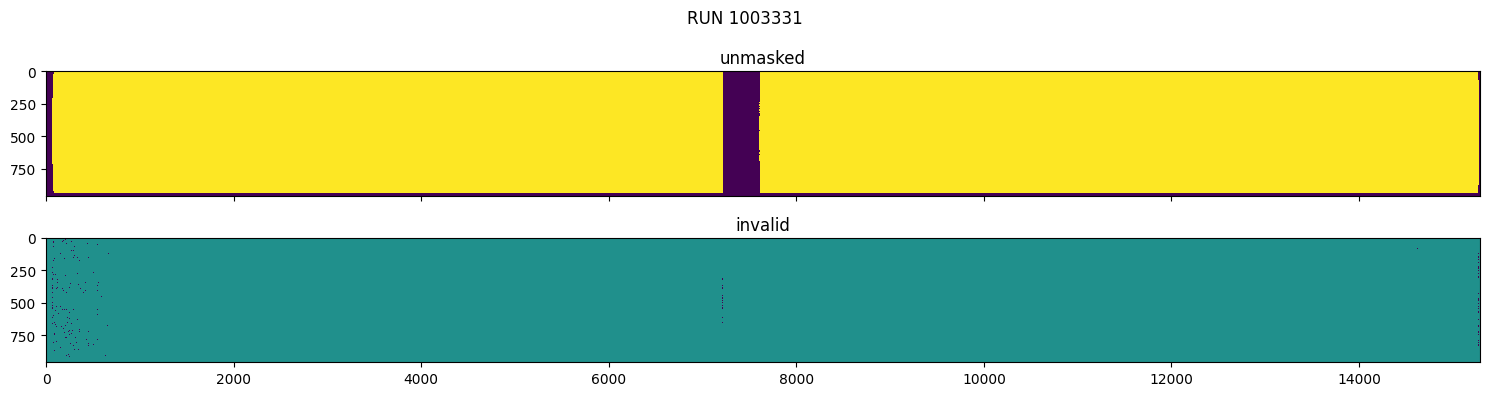

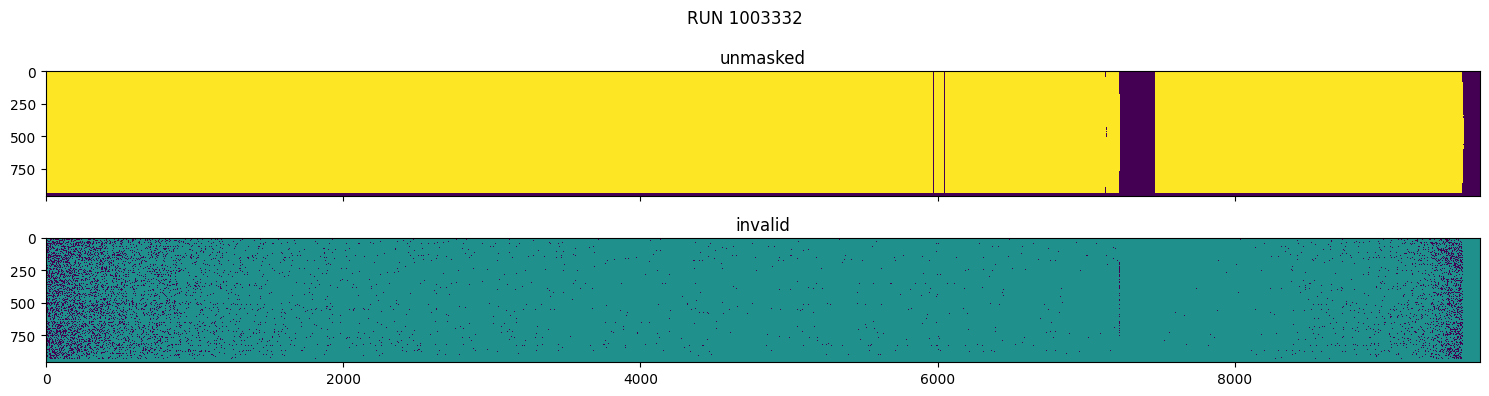

In [ ]:
# |label: fig-good
plot_unmasked_and_invalid(red_tests, 1003331)
plot_unmasked_and_invalid(blue_tests, 1003332)

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()